# 利用K-means聚类算法对未标注数据分组

**主要内容**
+ K-means聚类算法
+ 对聚类得到的簇进行后处理
+ 二分K-means聚类算法

### K-means

<span style='color: red'>聚类</span>是一种无监督学习，将相似的对象归到同一个簇中。几乎可以用于所有对象，簇内的对象越相似，聚类的效果越好。

<span style='color: red'>K-means</span>可以发现K（用户指定）个簇，且每个簇的中心采用簇中所含值的均值计算而成。

聚类与分类的最大不同在于，分类的目标事先已知，而聚类则不一样。其产生的结果与分类不同，类别没有预先定义，聚类有时候也称为<span style='color: red'>无监督分类（unsupervised classification）</span>。

聚类试图将相似对象归入到同一簇，将不相似对象归到不同簇（物以类聚）。

**K-Means聚类**
+ 优点：容易实现
+ 缺点：可能收敛到局部最小值，在大规模数据集上收敛比较慢
+ 适用数据类型：数值型数据

**伪代码**
```
创建K个点作为起始质心（经常是随机选择）
当任意一点的簇分配结果发生变化时
    对数据集中的每个数据点
        对每个质心
            计算质心与数据点之间的距离
        将数据点分配到其最近（最近是基于某种距离计算来度量的，可以是任意距离度量方法）的簇
    对每个簇，计算簇中所有点的均值并将均值作为质心
```

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin

In [2]:
# load dataset
def load_dataset(file_name):
    data = []
    fr = open(file_name)
    for line in fr.readlines():
        cur_line = line.strip().split('\t')
        filter_line = list(map(float, cur_line))
        data.append(filter_line)
    return np.mat(data)

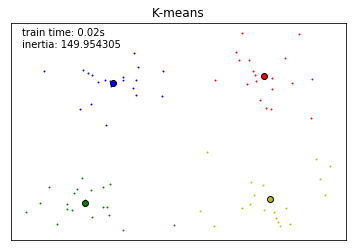

clustering inertia:
 [[ 2.80293085 -2.7315146 ]
 [-2.46154315  2.78737555]
 [-3.38237045 -2.9473363 ]
 [ 2.6265299   3.10868015]]


In [3]:
data = load_dataset('testSet.txt')

# Compute clustering with KMeans
random_state = 170
n_clusters = 4
t0 = time.time()
k_means = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10).fit(data)
t_cost = time.time() - t0

# plot result
k_means_cluster_centers = k_means.cluster_centers_
k_means_labels = k_means.labels_

colors = list('ybgr')
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    plt.plot(data[my_members, 0], data[my_members, 1], 'w', markerfacecolor=col, marker='.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=6)
plt.title('K-means')
plt.xticks(())
plt.yticks(())
plt.text(-5.5, 4.5, 'train time: %.2fs\ninertia: %f' % (t_cost, k_means.inertia_))
plt.show()
print('clustering inertia:\n', k_means.cluster_centers_)

### 使用后处理来提高聚类性能

K-means算法收敛但聚类效果较差的原因是收敛到了局部最小值，而非全局最小值。

一种用于度量聚类效果的指标是SSE（Sum of Squared Error，误差平方和，`sklearn.KMeans`的`inertia_`属性）。SSE值越小表示数据点越接近于它们的质心，聚类效果越好。因为对误差取了平方，因此更加重视那些远离中心的点。一种肯定可以降低SSE值的方法是增加簇的个数，但这违背了聚类的目标。聚类的目标是在保持簇数目不变的情况下提高簇的质量。

一种方法是将具有最大SSE值的簇划分为两个簇。具体实现时可以将最大簇包含的点过滤出来并在这些点上运行K-Means算法，同时为了保持簇总数不变，可以将某两个簇进行合并。

有两种量化的方法：合并最近的质心，或者合并使两个使得SSE增幅最小的质心。第一种思路通过计算所有质心之间的距离，然后合并距离最近的两个点来实现。第二种方法需要合并两个簇然后计算总SSE值。必须在所有可能的两个簇上重复上述处理过程，直到找到合并最佳的两个簇为止。

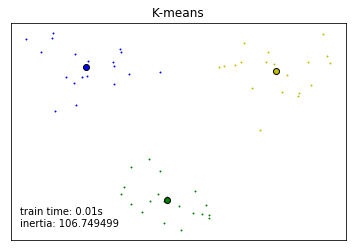

clustering inertia:
 [[ 2.93386365  3.12782785]
 [-2.94737575  3.3263781 ]
 [-0.45965615 -2.7782156 ]]


In [4]:
data = load_dataset('testSet2.txt')

# Compute clustering with KMeans
random_state = 170
n_clusters = 3
t0 = time.time()
k_means = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10).fit(data)
t_cost = time.time() - t0

# plot result
k_means_cluster_centers = k_means.cluster_centers_
k_means_labels = k_means.labels_

colors = list('ybgr')
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    plt.plot(data[my_members, 0], data[my_members, 1], 'w', markerfacecolor=col, marker='.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=6)
plt.title('K-means')
plt.xticks(())
plt.yticks(())
plt.text(-5.0, -4.0, 'train time: %.2fs\ninertia: %f' % (t_cost, k_means.inertia_))
plt.show()
print('clustering inertia:\n', k_means.cluster_centers_)

### 二分K-Means（bisecting K-means）

为克服K-Means算法收敛局部最小值的问题，有人提出了一个称为**二分K-Means（bisecting K-means）的算法**。该算法首先将所有点作为一个簇，然后将该簇一分为二。之后选择其中一个簇继续进行划分，选择哪一个簇进行划分取决于对其划分是否可以最大程度降低SSE值。上述基于SSE的划分过程不断重复，直到得到用户指定的簇数目为止。

**伪代码**
```
将所有点看成一个簇
当簇数目小于k时
    对于每一个簇
        计算总误差
        在给定簇上面进行K-means聚类（k=2）
        计算将该簇一分为二之后的总误差
    选择使得误差最小的那个簇进行划分操作
```

另一种做法是选择最大SSE最大的那个簇进行划分，直到簇数目达到用户指定的数目为止。